# CIFAR‑10 Image Classification: Graph‑based vs. CNN Baseline

In this notebook we compare two approaches for CIFAR‑10 image classification:
1. **Graph‑based Model:** Each 32×32 CIFAR‑10 image is divided into 16 patches (a 4×4 grid, each patch is 8×8). These patches become node features, and adjacent patches are connected to form a graph. We then process the graph using our unified CNN‑GNN model (which integrates a modern CNN encoder with dropout, batch normalization, and residual connections into a GNN).
2. **CNN Baseline:** A conventional convolutional neural network for CIFAR‑10 classification.

We train both models and compare their learning curves and performance.


In [1]:
# Import libraries and set up device
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# TGraphX imports
from models.cnn_gnn_model import CNN_GNN_Model
from core.graph import Graph, GraphBatch
from core.dataloader import GraphDataset, GraphDataLoader
from core.utils import get_device

device = get_device()
print("Using device:", device)


Using device: cuda


## Custom Dataset: CIFAR‑10 Graph Dataset

We define a dataset that loads CIFAR‑10 images and converts each image into a graph using the helper above.


In [2]:
from torchvision.datasets import CIFAR10

class CIFAR10GraphDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, grid_size=4):
        self.dataset = CIFAR10(root=root, train=train, download=True, transform=transform)
        self.grid_size = grid_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]  # img is a tensor, label is an int
        # Convert image (3, 32, 32) into graph (node_features and edge_index)
        node_features, edge_index = image_to_graph(img, grid_size=self.grid_size)
        from core.graph import Graph
        graph = Graph(node_features, edge_index)
        return graph, label

# Define transform to convert PIL image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    # Optionally add normalization
])


## DataLoader Setup

We use the custom `GraphDataLoader` from TGraphX with a collate function that batches (graph, label) tuples.


In [3]:
def graph_label_collate_fn(batch):
    """Batch a list of (Graph, label) tuples."""
    graphs, labels = zip(*batch)
    from core.graph import GraphBatch
    return GraphBatch(graphs), torch.tensor(labels, dtype=torch.long)

train_dataset = CIFAR10GraphDataset(root='./data', train=True, transform=transform, grid_size=4)
test_dataset = CIFAR10GraphDataset(root='./data', train=False, transform=transform, grid_size=4)

from core.dataloader import GraphDataLoader
train_loader = GraphDataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=graph_label_collate_fn)
test_loader  = GraphDataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=graph_label_collate_fn)


## Helper Functions: Converting an Image to a Graph

Each CIFAR‑10 image (3×32×32) is split into a 4×4 grid of patches (each 3×8×8).
Edges are created between patches that are adjacent (right and bottom neighbors).


In [4]:
import torch
import random

def image_to_graph(img, grid_size=4, extra_edge_prob=0.1):
    """
    Converts an image tensor (C, H, W) into a graph.
    Divides the image into grid_size x grid_size patches.
    Creates structured edges between adjacent patches and adds extra random edges.

    Returns:
        node_features: Tensor of shape (grid_size*grid_size, C, patch_H, patch_W)
        edge_index: Tensor of shape [2, E]
    """
    C, H, W = img.shape
    patch_H = H // grid_size
    patch_W = W // grid_size
    nodes = []
    for i in range(grid_size):
        for j in range(grid_size):
            patch = img[:, i*patch_H:(i+1)*patch_H, j*patch_W:(j+1)*patch_W]
            nodes.append(patch)
    node_features = torch.stack(nodes, dim=0)

    edges = []
    def node_index(i, j):
        return i * grid_size + j
    for i in range(grid_size):
        for j in range(grid_size):
            idx = node_index(i, j)
            if j < grid_size - 1:
                edges.append([idx, node_index(i, j+1)])
                edges.append([node_index(i, j+1), idx])
            if i < grid_size - 1:
                edges.append([idx, node_index(i+1, j)])
                edges.append([node_index(i+1, j), idx])
    # Extra random edges
    total_nodes = grid_size * grid_size
    for i in range(total_nodes):
        for j in range(i+1, total_nodes):
            if random.random() < extra_edge_prob:
                edges.append([i, j])
                edges.append([j, i])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return node_features, edge_index

# Test the helper with a sample image from the dataset
sample_graph, sample_label = train_dataset[0]
print("Graph Sample Summary:")
print("-" * 40)
print(f"Label: {sample_label}")
print(f"Node features shape: {sample_graph.node_features.shape}")
print(f"Edge index shape: {sample_graph.edge_index.shape}")
print("First 10 edges:")
print(sample_graph.edge_index[:, :10])
print("-" * 40)


Graph Sample Summary:
----------------------------------------
Label: 6
Node features shape: torch.Size([16, 3, 8, 8])
Edge index shape: torch.Size([2, 78])
First 10 edges:
tensor([[0, 1, 0, 4, 1, 2, 1, 5, 2, 3],
        [1, 0, 4, 0, 2, 1, 5, 1, 3, 2]])
----------------------------------------


## Model 1: Graph-based Classifier using TGraphX

Our graph-based model uses node features from image patches. For each graph:
- **Input shape:** (3, 8, 8) per node.
- **Hidden shape:** We choose (16, 8, 8).
- **Pooling:** Mean pooling over nodes.
- **Classifier:** Outputs 10 classes.


In [5]:
# Sample configuration dictionary
config = {
    "cnn_params": {
         "in_channels": 3,              # Number of input channels for the CNN encoder (e.g. 3 for RGB)
         "out_features": 64,            # Number of output channels for the CNN encoder (feature map channels)
         "num_layers": 2,               # Total number of convolutional layers in the CNN encoder
         "hidden_channels": 64,         # Number of channels in the intermediate layers of the CNN encoder
         "dropout_prob": 0.3,           # Dropout probability used in the CNN encoder
         "use_batchnorm": True,         # Flag to use Batch Normalization in the CNN encoder
         "use_residual": True,          # Flag to enable residual (skip) connections in the CNN encoder
         "pool_layers": 2,              # Number of early layers on which to apply max pooling
         "debug": False,                # Debug flag to print internal shapes and stats during CNN encoding
         "return_feature_map": True     # When True, the CNN encoder returns a spatial feature map (not flattened)
    },
    "use_preencoder": False,              # Flag to enable the optional pre-encoder stage
    "pretrained_resnet": False,           # Flag to choose whether to load pretrained ResNet-18 weights for the pre-encoder
    "preencoder_params": {
         "in_channels": 3,             # Number of input channels for the pre-encoder (e.g. 3 for RGB)
         "out_channels": 32,           # Number of output channels from the pre-encoder
         "hidden_channels": 32         # Number of channels in the custom pre-encoder (if not using pretrained)
    },
    "gnn_in_dim": (64, 5, 5),            # Input dimensions for the GNN layers (must match CNN encoder output)
    "gnn_hidden_dim": (128, 5, 5),         # Hidden state dimensions for the GNN layers (multi-dimensional)
    "num_classes": 10,                   # Number of classes for classification (e.g. 10 for CIFAR-10)
    "num_gnn_layers": 4,                 # Total number of GNN message passing layers
    "gnn_dropout": 0.3,                  # Dropout probability to use in the GNN layers
    "residual": True,                    # Flag to enable residual (skip) connections in the GNN layers
    "aggregator_params": {               # Additional parameters for the deep CNN aggregator used in the GNN layers
         "num_layers": 4,               # Number of convolutional layers in the aggregator CNN
         "dropout_prob": 0.3,           # Dropout probability in the aggregator CNN
         "use_batchnorm": True          # Flag to use BatchNorm in the aggregator CNN
    }
}

from models.pre_encoder import PreEncoder  # Import the PreEncoder module
from models.cnn_gnn_model import CNN_GNN_Model  # Import the unified CNN-GNN model
from core.utils import get_device             # Import helper function to get the available device

# Instantiate the pre-encoder if enabled in the configuration.
if config["use_preencoder"]:
    pre_encoder = PreEncoder(
         in_channels=config["preencoder_params"]["in_channels"],  # Pass input channels for pre-encoder
         out_channels=config["preencoder_params"]["out_channels"],# Pass output channels for pre-encoder
         use_pretrained=config["pretrained_resnet"],              # Whether to use pretrained ResNet-18 weights
         custom_params=config.get("preencoder_params")            # Additional custom parameters (if any)
    )
else:
    pre_encoder = None  # No pre-encoder is used; raw input is directly passed to the CNN encoder.

# Create the unified CNN-GNN model using the configuration parameters.
model = CNN_GNN_Model(
    cnn_params=config["cnn_params"],         # Configuration for the CNN encoder
    gnn_in_dim=config["gnn_in_dim"],           # Input dimensions for the GNN layers (matches CNN encoder output)
    gnn_hidden_dim=config["gnn_hidden_dim"],   # Hidden dimensions for the GNN layers
    num_classes=config["num_classes"],         # Number of classes for classification
    num_gnn_layers=config["num_gnn_layers"],   # Total number of GNN layers to stack
    gnn_dropout=config["gnn_dropout"],         # Dropout rate for the GNN layers
    residual=config["residual"],               # Enable residual connections in the GNN layers
    aggregator_params=config["aggregator_params"],  # Parameters for the deep CNN aggregator in GNN layers
    pre_encoder=pre_encoder                    # Pass the optional pre-encoder (if instantiated)
)

# Get the available device (GPU if available, else CPU)
device = get_device()

# Move the model to the chosen device.
model.to(device)


CNN_GNN_Model(
  (encoder): CNNEncoder(
    (cnn): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.3, inplace=False)
        (4): SafeMaxPool2d()
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout2d(p=0.3, inplace=False)
          (4): SafeMaxPool2d()
        )
        (proj): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      )
    )
    (conv1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (gnn_layers): ModuleList(
    (0): ConvMessagePassing(
      (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    

## Model 2: CNN Baseline for CIFAR‑10

Below is a simple CNN architecture for CIFAR‑10 classification.


In [6]:
# Define a simple CNN baseline for CIFAR‑10 classification.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 16 -> 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn_model = SimpleCNN(num_classes=10)
cnn_model.to(device)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [7]:
import torch.optim as optim

graph_optimizer = optim.Adam(model.parameters(), lr=0.001)
cnn_optimizer   = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [8]:
from torchvision.datasets import CIFAR10

# Create DataLoaders for the CNN baseline using the original CIFAR‑10 images.
train_cifar = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_cifar  = CIFAR10(root='./data', train=False, download=True, transform=transform)

cnn_train_loader = torch.utils.data.DataLoader(train_cifar, batch_size=32, shuffle=True)
cnn_test_loader  = torch.utils.data.DataLoader(test_cifar, batch_size=32, shuffle=False)


## Training Loop

We train both models on the CIFAR‑10 training set for a few epochs and compare their performance.
For the graph-based model, the input graphs are converted from image patches, while the CNN uses the original images.


In [9]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def evaluate_model(model, loader, device, is_cnn=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            if is_cnn:
                images, labels = data
                images = images.to(device)
                outputs = model(images)
            else:
                graphs, labels = data
                graphs = graphs.to(device)
                outputs = model(graphs.node_features, graphs.edge_index, graphs.edge_features, graphs.batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    ba = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return ba, f1

num_epochs = 50
graph_train_losses = []
graph_ba_list = []
graph_f1_list = []
cnn_train_losses = []
cnn_ba_list = []
cnn_f1_list = []

print("\nTraining Both Models Simultaneously:\n")
header = "{:<6s} {:<14s} {:<14s} {:<14s} {:<14s} {:<14s} {:<14s}".format(
    "Epoch", "TGraphX Loss", "TGraphX BA", "TGraphX F1", "CNN Loss", "CNN BA", "CNN F1"
)
print(header)
print("-" * len(header))

for epoch in range(1, num_epochs + 1):
    # --- Train Graph-based Model ---
    model.train()
    total_graph_loss = 0.0
    total_graph_samples = 0
    graph_nan_detected = False  # flag to mark if NaN is detected in graph training
    for batch, labels in train_loader:
        # Optionally, you could print the batch shape for the first batch
        #if total_graph_samples == 0:
        #    print("Batch node_features shape:", batch.node_features.shape)
        batch = batch.to(device)
        labels = labels.to(device)
        graph_optimizer.zero_grad()

        outputs = model(batch.node_features, batch.edge_index, batch.edge_features, batch.batch)
        if torch.isnan(outputs).any():
            print("Model output contains NaN!")
            print("Output stats: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
                outputs.mean().item(), outputs.std().item(), outputs.min().item(), outputs.max().item()
            ))
            graph_nan_detected = True
            break

        loss = criterion(outputs, labels)
        if torch.isnan(loss):
            print("NaN loss detected in Graph model!")
            graph_nan_detected = True
            break

        loss.backward()
        graph_optimizer.step()
        total_graph_loss += loss.item() * labels.size(0)
        total_graph_samples += labels.size(0)

    if graph_nan_detected or total_graph_samples == 0:
        epoch_graph_loss = float('nan')
        graph_train_losses.append(epoch_graph_loss)
        print(f"Epoch {epoch}: Graph training encountered NaN values.")
    else:
        epoch_graph_loss = total_graph_loss / total_graph_samples
        graph_train_losses.append(epoch_graph_loss)

    # --- Train CNN Baseline ---
    cnn_model.train()
    total_cnn_loss = 0.0
    total_cnn_samples = 0
    for images, labels in cnn_train_loader:
        cnn_optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()
        total_cnn_loss += loss.item() * labels.size(0)
        total_cnn_samples += labels.size(0)
    epoch_cnn_loss = total_cnn_loss / total_cnn_samples
    cnn_train_losses.append(epoch_cnn_loss)

    # --- Evaluate Models ---
    graph_ba, graph_f1 = evaluate_model(model, test_loader, device, is_cnn=False)
    cnn_ba, cnn_f1 = evaluate_model(cnn_model, cnn_test_loader, device, is_cnn=True)

    # Store metrics for plotting
    graph_ba_list.append(graph_ba)
    graph_f1_list.append(graph_f1)
    cnn_ba_list.append(cnn_ba)
    cnn_f1_list.append(cnn_f1)

    print("{:<6d} {:<14.4f} {:<14.4f} {:<14.4f} {:<14.4f} {:<14.4f} {:<14.4f}".format(
        epoch, epoch_graph_loss, graph_ba, graph_f1, epoch_cnn_loss, cnn_ba, cnn_f1
    ))

print("\nTraining complete!")



Training Both Models Simultaneously:

Epoch  TGraphX Loss   TGraphX BA     TGraphX F1     CNN Loss       CNN BA         CNN F1        
------------------------------------------------------------------------------------------------
1      2.0022         0.2426         0.1872         1.7230         0.5253         0.5077        
2      1.8962         0.1995         0.1667         1.5160         0.5537         0.5324        
3      1.8684         0.2752         0.2478         1.4430         0.6076         0.5956        
4      1.8351         0.3055         0.2867         1.3950         0.6282         0.6231        
5      1.8079         0.3188         0.3029         1.3538         0.6285         0.6304        
6      1.7852         0.3230         0.3016         1.3176         0.5818         0.5693        
7      1.7546         0.3071         0.2837         1.2903         0.6729         0.6684        
8      1.7229         0.3414         0.3130         1.2607         0.6744         0.6720

## Learning Curve Comparison

Below we plot the training loss curves for both models.


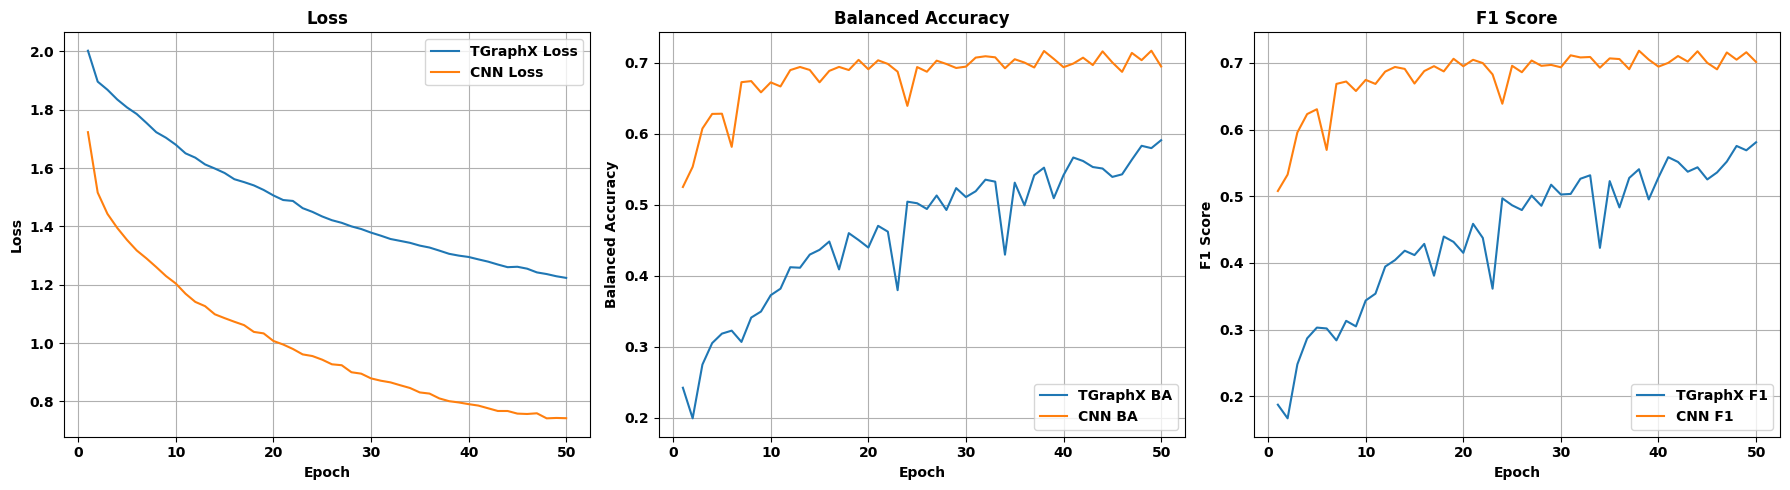

In [10]:
import matplotlib.pyplot as plt

# Assume these lists are populated during training:
# graph_train_losses, graph_ba_list, graph_f1_list,
# cnn_train_losses, cnn_ba_list, cnn_f1_list

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Loss plot: Compare TGraphX and CNN losses in the same plot
axs[0].plot(epochs, graph_train_losses, color='tab:blue', label='TGraphX Loss')
axs[0].plot(epochs, cnn_train_losses, color='tab:orange', label='CNN Loss')
axs[0].set_title("Loss")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid(True)
axs[0].legend()

# Balanced Accuracy plot: Compare TGraphX and CNN BA in the same plot
axs[1].plot(epochs, graph_ba_list, color='tab:blue', label='TGraphX BA')
axs[1].plot(epochs, cnn_ba_list, color='tab:orange', label='CNN BA')
axs[1].set_title("Balanced Accuracy")
axs[1].set_ylabel("Balanced Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].grid(True)
axs[1].legend()

# F1 Score plot: Compare TGraphX and CNN F1 in the same plot
axs[2].plot(epochs, graph_f1_list, color='tab:blue', label='TGraphX F1')
axs[2].plot(epochs, cnn_f1_list, color='tab:orange', label='CNN F1')
axs[2].set_title("F1 Score")
axs[2].set_ylabel("F1 Score")
axs[2].set_xlabel("Epoch")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()
